In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
from MSMRD.trajectories import allTrajs
%matplotlib inline

In [2]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [3]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 48
        self.entryRings = 6
        self.exitRings = 4
        self.radialPartitions = self.entryRings + self.exitRings
        self.radialIncrementEntry = (self.entryRad - self.innerMSMrad)/float(self.entryRings)
        self.radialIncrementExit = (self.bathRad - self.entryRad)/float(self.exitRings)
        self.Ncenters = len(self.centers)
        self.bathIndex = self.Ncenters + self.radialPartitions*self.angularPartitions
        
    def getAngularState(self, coord):
        theta = np.arctan2(coord[1], coord[0]) + np.pi
        if theta == 2*np.pi:
            return 0
        return int(theta*self.angularPartitions/(2*np.pi))
    
    def getRing(self, radius, increment, lowerBound):
        ring = 0
        upperBound = lowerBound
        while radius > upperBound:
            upperBound += increment
            ring += 1
        return ring - 1
    
    def getRing2(self, radius, increment, lowerBound):
        return int((radius-lowerBound)/increment)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        # Entry states
        elif radius < self.entryRad:
            angularState = self.getAngularState(coord)
            ringNumber = int((radius-self.innerMSMrad)/self.radialIncrementEntry)
            return self.Ncenters + ringNumber * self.angularPartitions + angularState
        elif radius < self.bathRad:
            angularState = self.getAngularState(coord)
            ringNumber = int((radius-self.entryRad)/self.radialIncrementExit)
            return self.Ncenters + (ringNumber + self.entryRings) * self.angularPartitions + angularState
        elif radius > self.bathRad:
            angularState = self.getAngularState(coord)
            return self.Ncenters + self.radialPartitions*self.angularPartitions + angularState
        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
        # entry states
        for k in range(self.entryRings):
            for i in range(self.angularPartitions):
                j = i + self.Ncenters + self.angularPartitions * k;
                r = self.innerMSMrad + (k + 0.5)  * self.radialIncrementEntry
                th = i*int_th + 0.5*int_th
                self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # exit states
        for k in range(self.exitRings):
            for i in range(self.angularPartitions):
                j = i + self.Ncenters + self.angularPartitions * (self.entryRings + k) ;
                r = self.entryRad + (k + 0.5)  * self.radialIncrementExit
                th = i*int_th + 0.5*int_th
                self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # bath states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + (self.entryRings + self.exitRings)*self.angularPartitions;
            r = 0.5*(self.bathRad + self.bathRadOut)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename
        for i in range(self.angularPartitions*self.entryRings):
            statename = 'Entry state ' + str(i)
            j = self.Ncenters + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions*self.exitRings):
            statename = 'Exit state ' + str(i)
            j = self.Ncenters + self.entryRings * self.angularPartitions + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Bath state ' + str(i)
            j = self.Ncenters + self.radialPartitions * self.angularPartitions + i
            self.regionMap[j] = statename

In [4]:
def computeMeanTransitionTimes(timestep, dTrajs, Nstates, bathIndex, stride):
    sumTau = np.zeros((Nstates+1, Nstates+1))
    counts = np.zeros((Nstates+1, Nstates+1))
    for traj in dTrajs:
        dTraj = traj[::stride]
        i = 1
        tau = 1
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            if dTraj[i] == dTraj[i-1]:
                tau += 1
            else:
                if dTraj[i] < Nstates or dTraj[i] >= bathIndex:
                    if dTraj[i] >= bathIndex:
                        currentState = Nstates
                    else:
                        currentState = dTraj[i]
                    if not np.in1d(currentState, statesVisited):
                        sumTau[transitionFrom, currentState] += tau
                        counts[transitionFrom, currentState] += 1
                        if nextTransitionIndex < 0:
                            nextTransitionIndex = i
                        statesVisited.append(currentState)
                        tau +=1
                    else:
                        tau += 1
                    if len(statesVisited) == Nstates:
                        transitionFrom = dTraj[nextTransitionIndex]
                        if transitionFrom >= bathIndex:
                            transitionFrom = Nstates
                        statesVisited = [transitionFrom]
                        i = nextTransitionIndex
                        nextTransitionIndex = -1
                        tau = 1 
                else:
                    tau += 1
    meanTransitionTimes = np.zeros((Nstates+1, Nstates+1))
    for i in range(0, Nstates+1):
        for j in range(0, Nstates+1):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep*stride
    return meanTransitionTimes

In [15]:
numfiles = 1
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_R4_RT1E7_dt001_SI10_'
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object
#alltrajs = allTrajs_inner([])
dimension = 2
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], 10):
        print 'timestep not constant'
    traj = data[::100,1:dimension+1]
    alltrajs.Trajs.append(traj)

In [16]:
%%time
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
#centersdict = alltrajs.getMilestones()
#centers = alltrajs.getMilestonesArray()

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 232 ms


In [30]:
MTT = computeMeanTransitionTimes(0.01, dtrajs, 9, alltrajs.bathIndex, 1)

IndexError: index 25 is out of bounds for axis 0 with size 10

296

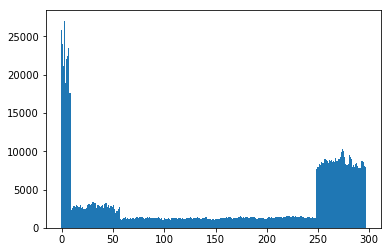

In [21]:
dhist = discreteHistogram(dtrajs[0])
np.amax(dtrajs[0])

In [26]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 20)

estimating MaximumLikelihoodMSM: 100% (7/7) [######################] eta 00:00 |

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 7 Text yticklabel objects>)

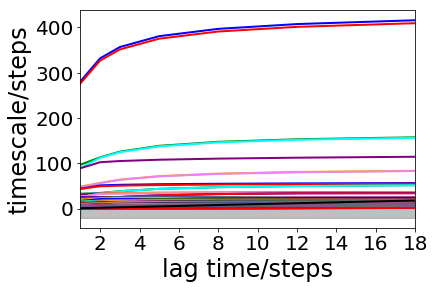

In [27]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
MSMradius = 4.0
X = np.arange(-MSMradius, MSMradius, 0.01)
Y = np.arange(-MSMradius, MSMradius, 0.01)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in alltrajs.Trajs:
    bath = np.where(np.linalg.norm(traj, axis=1) > 3.0)[0] 
    hist = np.histogram2d(traj[bath,1], traj[bath,0], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Zfull, 10, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.colorbar()

In [50]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 10
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)

In [14]:
milestoningCKtest = M.cktest(4)

ValueError: Cannot compute PCCA for non-reversible matrices. Set reversible=True when constructing the MSM.

(<matplotlib.figure.Figure at 0x7faf89ac7190>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf45f6c390>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7faf4589c2d0>]], dtype=object))

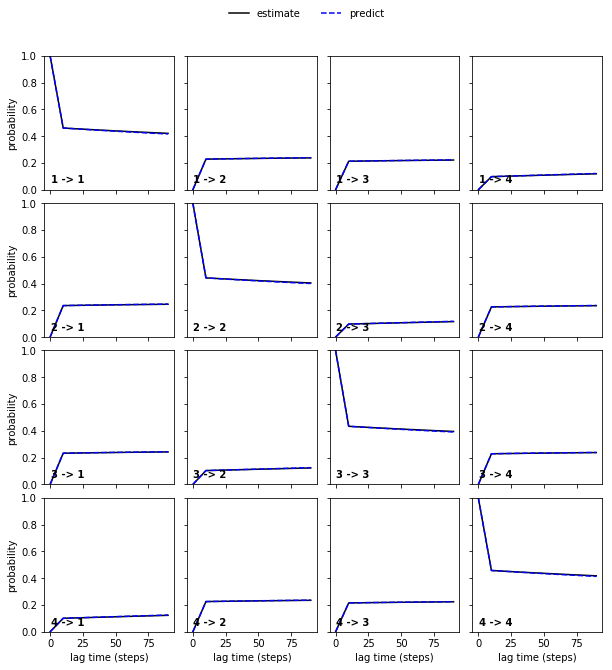

In [12]:
mplt.plot_cktest(milestoningCKtest)

In [40]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode = 2 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode][:], cmap=plt.cm.inferno, linewidths = 0, s=100)
#plt.colorbar()
#plt.clim(-0.05,0.05)

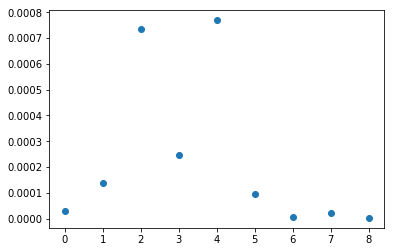

In [51]:
# Plot transition probabilities to bath state
T = M.transition_matrix
plt.plot(np.sum(T[:9,-24:],axis=1), 'o')

In [52]:
bathStates = range(alltrajs.bathIndex, len(T))
mfpt_fullMatrix = np.zeros((10,10))
for i in range(0, 9):
    mfpt_fullMatrix[i, 9] = M.mfpt(i, bathStates) * 0.01
    mfpt_fullMatrix[9, i] = M.mfpt(bathStates, i) * 0.01
    for j in range(0,9):
        if i != j:
            mfpt_fullMatrix[i,j] = M.mfpt(i,j) * 0.01

In [53]:
bathStates = range(alltrajs.bathIndex, len(T))
mfpt_tpt_fullMatrix = np.zeros((10,10))
for i in range(0, 9):
    mfpt_tpt_fullMatrix[i,9] = pyemma.msm.tpt(M, [i], bathStates).mfpt * 0.01
    mfpt_tpt_fullMatrix[9, i] = pyemma.msm.tpt(M, bathStates, [i]).mfpt * 0.01
    for j in range(0,9):
        if i != j:
            mfpt_tpt_fullMatrix[i,j] = pyemma.msm.tpt(M, [i], [j]).mfpt * 0.01

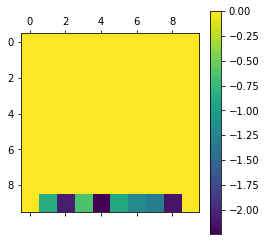

In [54]:
plt.matshow(mfpt_tpt_fullMatrix-mfpt_fullMatrix)
plt.colorbar()

In [55]:
import pickle
BDtransitionTimesMSM = pickle.load(open('MTTs_convergence.p'))

[ 0.1267687   0.14032557  0.17004847  0.13562028  0.17732414  0.13961568
  0.14437405  0.14781843  0.17096257  0.        ]


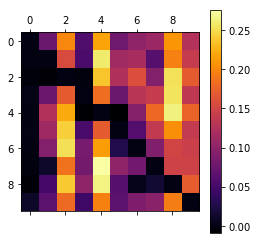

In [59]:
diff = np.zeros_like(mfpt_fullMatrix)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (mfpt_fullMatrix[i,j] - BDtransitionTimesMSM[48][i,j])/BDtransitionTimesMSM[48][i,j]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(abs(diff))
#plt.savefig('2DasymError.pdf')
print diff[:,9]

In [ ]:
diff = np.zeros_like(mfpt_fullMatrix)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (MTT[i,j] - BDtransitionTimesMSM[48][i,j])/BDtransitionTimesMSM[48][i,j]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(abs(diff))
#plt.savefig('2DasymError.pdf')
print diff[:,9]

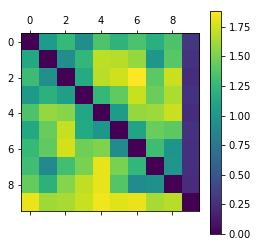

In [17]:
plt.matshow(MTT)
plt.colorbar()

In [12]:
def computeMeanTransitionTimesFromTrajs(dTrajs, timestep, Nstates, stride):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for traj in dTrajs:
        dTraj = traj[::stride]
        i = 0
        tau = 0
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            tau += 1
            if dTraj[i] != dTraj[i-1]:
                if len(statesVisited) == Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 0
                elif not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep * stride
    return meanTransitionTimes

In [13]:
fullMTT = computeMeanTransitionTimesFromTrajs(dtrajs, 0.01, 10, 1)

IndexError: index 11 is out of bounds for axis 1 with size 10

In [13]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = alltrajs.innerMSMrad
parameters['entryRadius'] = alltrajs.entryRad
parameters['bathRadius'] = alltrajs.bathRad
parameters['outerBathRadius'] = alltrajs.bathRadOut
parameters['NCenters'] = alltrajs.Ncenters
parameters['NangularPartitions'] = alltrajs.angularPartitions
parameters['entryRings'] = alltrajs.entryRings
parameters['exitRings'] = alltrajs.exitRings
parameters['lagtime'] = msm_lag
model = MSMmodel(T, minima, parameters)

In [14]:
import pickle
pickle.dump(model, open('../data/asym2D_longTraj_lag5_Nangular12_50Trajs_10divisions.p', 'wb'))

In [16]:
T.shape

(54, 54)

In [23]:
MSMmodelSmall = pickle.load(open('../data/asym2D_longTraj_lag10_Nangular90_rerun.p'))

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


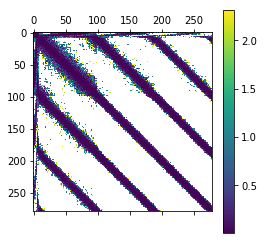

In [24]:
plt.matshow(np.abs(model.tmatrix-MSMmodelSmall.tmatrix)/model.tmatrix)
plt.colorbar()